
# Multi-Class Classification on Forest CoverType Dataset  
**Assignment: Model Building + Interpretability (SHAP)**

This notebook:
- Preprocesses the Forest CoverType dataset
- Trains a multi-class classifier
- Evaluates using cross-validation, accuracy, confusion matrix, classification report
- Explains predictions using SHAP


## 1. Imports

In [3]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import shap
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Load Dataset

In [4]:

# Dataset has no headers
data = pd.read_csv("covtype.data.gz", header=None)

# Column names based on documentation
num_features = [
    'Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
    'Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

wilderness = [f'Wilderness_Area{i}' for i in range(1,5)]
soil = [f'Soil_Type{i}' for i in range(1,41)]

columns = num_features + wilderness + soil + ['Cover_Type']
data.columns = columns

data.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## 3. Feature / Target Split

In [5]:

X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type'] - 1


## 4. Preprocessing

In [6]:

# Scale only continuous features
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])


## 5. Train-Test Split

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 6. Model Training

In [8]:

# Using XGBClassifier for optimized performance
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method='hist' # Efficient algorithm, utilizes hardware acceleration
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

## 7. Cross-Validation

In [9]:

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("CV Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


CV Accuracy Scores: [0.84261311 0.83837482 0.84265614 0.84253781 0.83963167]
Mean CV Accuracy: 0.8411627108531949


## 8. Evaluation on Test Set

In [10]:

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8413724258409851

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     42368
           1       0.84      0.88      0.86     56661
           2       0.85      0.89      0.87      7151
           3       0.86      0.86      0.86       549
           4       0.89      0.44      0.59      1899
           5       0.81      0.69      0.75      3473
           6       0.93      0.88      0.90      4102

    accuracy                           0.84    116203
   macro avg       0.86      0.78      0.81    116203
weighted avg       0.84      0.84      0.84    116203



## 9. Confusion Matrix

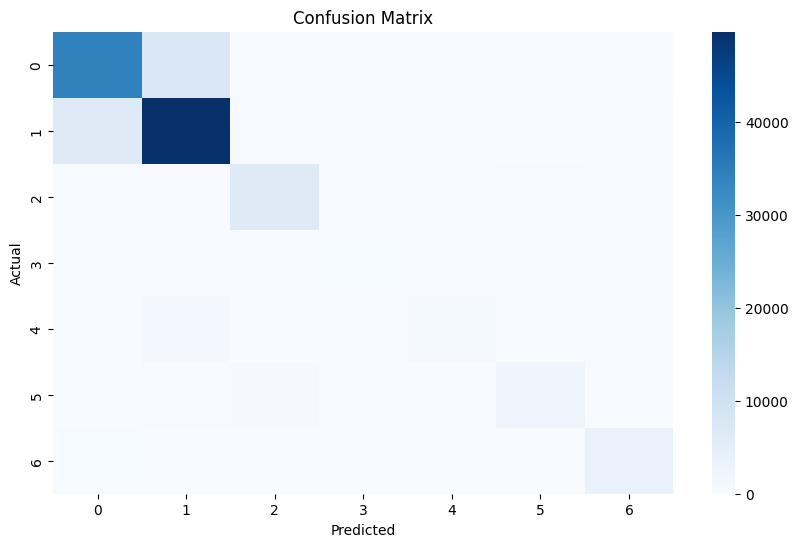

In [11]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 10. SHAP Model Explainability

In [12]:

# SHAP can be slow; sample data
X_sample = X_test.sample(100, random_state=42) # Reduced sample for KernelExplainer speed

# Create a wrapper to avoid attribute errors with the XGBClassifier object
def predict_wrapper(data):
    return model.predict_proba(data)

# Use KernelExplainer (Model-Agnostic)
# Using a small background dataset (kmeans) for speed
X_background = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(predict_wrapper, X_background)

# Calculate SHAP values (nsamples limits the number of evaluations)
shap_values_array = explainer.shap_values(X_sample, nsamples=100)

# Convert 3D array (Samples, Features, Classes) to list of 2D arrays for compatibility
import numpy as np
if isinstance(shap_values_array, np.ndarray) and len(shap_values_array.shape) == 3:
    shap_values = [shap_values_array[:, :, i] for i in range(shap_values_array.shape[2])]
else:
    shap_values = shap_values_array


  0%|          | 0/100 [00:00<?, ?it/s]

## 11. Global Feature Importance (SHAP)

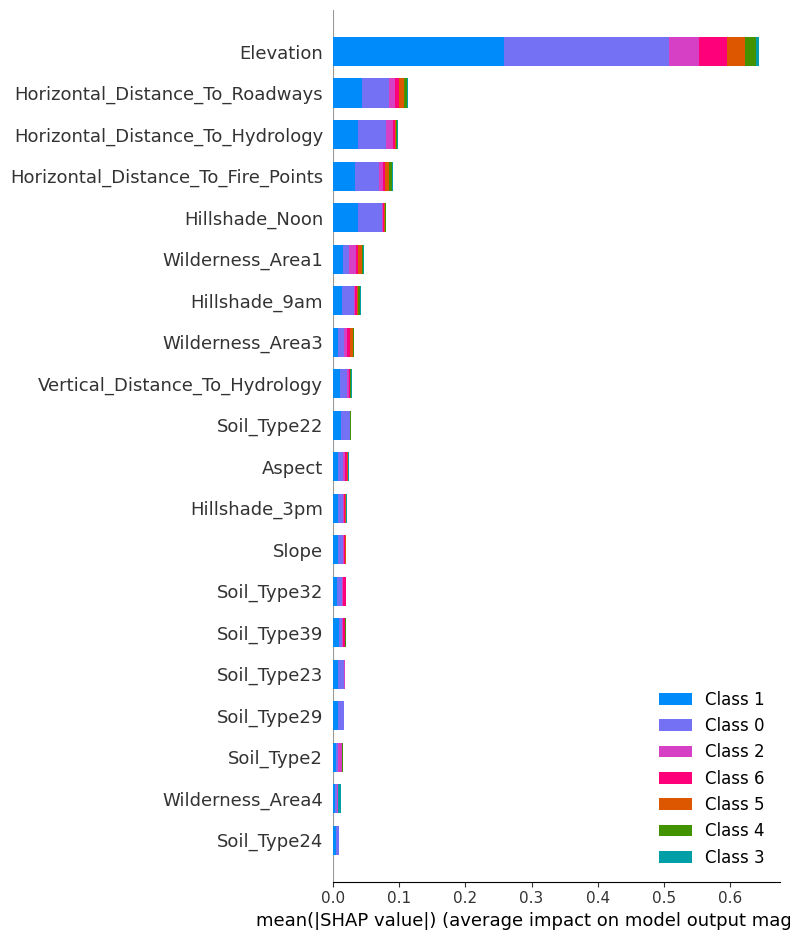

In [13]:

shap.summary_plot(shap_values, X_sample, plot_type="bar")


## 12. Explain Individual Prediction

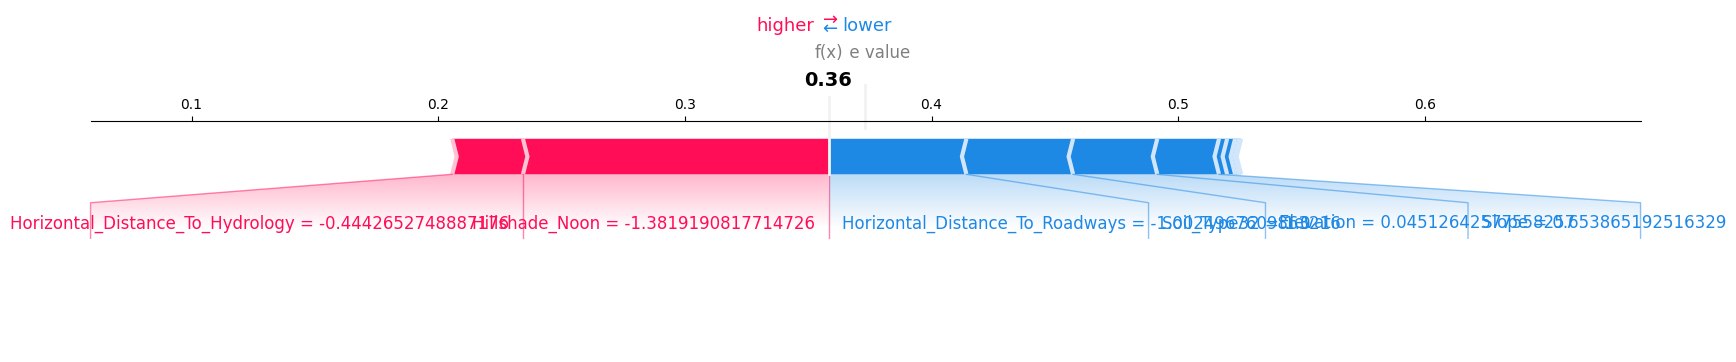

In [14]:

index = 0
# Force plot for the first class (class 0)
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][index],
    X_sample.iloc[index],
    matplotlib=True
)



## Conclusion

- XGBoost with Histogram method handles large datasets efficiently.
- Cross-validation shows stable accuracy.
- SHAP provides both global and local interpretability.
- Elevation and soil types are dominant predictors.
